<h1 style="text-align: center;">Weather Impact on Chicago Taxi Trips</h1>

## Project overview

This project analizes taxi trips patterns in Chicago. It examines the top drop-off neighborhoods, the most popular taxi companies based on user demand.
It also includes a hypothesis test to evaluate wether rain affects the average duration of taxi trips from Loop to O'hare International Airport.

## Initialization and data inspection plan

The dataset will be loaded and examined to verify their structure, data types, and consistency. This process includes reviewing dataset dimensions, validating variable formats, identifying and handling missing values, detecting duplicate records, and assessing categorical and numerical fields for potential issues. These steps ensure the data is properly prepared for exploratory analysis and hypothesis testing.

### 1. Load and inspect datasets

#### 1.1. Load required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from itables import show
import itertools
import unicodedata
from ticks_configuration import setup_minor_ticks
from matplotlib.ticker import MultipleLocator, MaxNLocator, AutoMinorLocator
import seaborn as sns
from scipy import stats

#### 1.2. Load datasets

In [2]:
# Load CSV files into pandas DataFrames
df_company_trips = pd.read_csv('datasets/project_sql_result_01.csv', sep=',')
df_avg_trips_by_dropoff = pd.read_csv('datasets/project_sql_result_04.csv', sep=',')
df_loop_to_ohare_trips = pd.read_csv('datasets/project_sql_result_07.csv', sep=',')

#### 1.3. Inspect dataset structure 

In [3]:
df_company_trips.info()

<class 'pandas.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   company_name  64 non-null     str  
 1   trips_amount  64 non-null     int64
dtypes: int64(1), str(1)
memory usage: 1.1 KB


In [4]:
df_company_trips.shape
df_company_trips.columns

Index(['company_name', 'trips_amount'], dtype='str')

In [5]:
show(df_company_trips.head(5))
show(df_company_trips.tail(5))
show(df_company_trips.sample(5))

Loading ITables v2.7.0 from the internet... (need help?)


Loading ITables v2.7.0 from the internet... (need help?)


Loading ITables v2.7.0 from the internet... (need help?)


In [6]:
print(df_company_trips.duplicated().sum())
print()
print(df_company_trips.nunique())

0

company_name    64
trips_amount    56
dtype: int64


The dataframe df_company_trips contains 64 rows and 2 columns, with no missing values. Data types are appropriate for their content: company_name is stored as str, and trips_amount as int64. Columns names follow a consistent format, without extra spaces and separated by underscores. The initial inspection shows no duplicated rows or duplicate values in the company_name column. Nevertheless, a new column with canonical names will be created, and duplicate checks will be performed again.

In [7]:
df_avg_trips_by_dropoff.info()

<class 'pandas.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     str    
 1   average_trips          94 non-null     float64
dtypes: float64(1), str(1)
memory usage: 1.6 KB


In [8]:
print(df_avg_trips_by_dropoff.shape)
df_avg_trips_by_dropoff.columns

(94, 2)


Index(['dropoff_location_name', 'average_trips'], dtype='str')

In [9]:
show(df_avg_trips_by_dropoff.head(5))
show(df_avg_trips_by_dropoff.tail(5))
show(df_avg_trips_by_dropoff.sample(5))

Loading ITables v2.7.0 from the internet... (need help?)


Loading ITables v2.7.0 from the internet... (need help?)


Loading ITables v2.7.0 from the internet... (need help?)


In [10]:
print(df_avg_trips_by_dropoff.duplicated().sum())
print()
print(df_avg_trips_by_dropoff.nunique())

0

dropoff_location_name    94
average_trips            94
dtype: int64


The df_avg_trips_by_dropoff dataframe contains 94 rows and 2 columns, with no missing values. Data types are appropriate for their content: dropoff_location_name is stored as str, and average_trips as float64. Column names follows a consistent format, without extra spaces and separated by underscores. The initial inspection shows no duplicated rows or duplicated values in the dropoff_location_name column. Nevertheless, a new column with canonical names will be created, and duplicated checks will be performed again.

In [11]:
df_loop_to_ohare_trips.info()


<class 'pandas.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   str    
 1   weather_conditions  1068 non-null   str    
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), str(2)
memory usage: 25.2 KB


In [12]:
print(df_loop_to_ohare_trips.shape)
df_loop_to_ohare_trips.columns

(1068, 3)


Index(['start_ts', 'weather_conditions', 'duration_seconds'], dtype='str')

In [13]:
show(df_loop_to_ohare_trips.head(5))
show(df_loop_to_ohare_trips.tail(5))
show(df_loop_to_ohare_trips.sample(5))

Loading ITables v2.7.0 from the internet... (need help?)


Loading ITables v2.7.0 from the internet... (need help?)


Loading ITables v2.7.0 from the internet... (need help?)


In [14]:
print(df_loop_to_ohare_trips.duplicated().sum())
print()
print(df_loop_to_ohare_trips.nunique())

197

start_ts               81
weather_conditions      2
duration_seconds      495
dtype: int64


In [15]:
show(df_loop_to_ohare_trips[df_loop_to_ohare_trips.duplicated(keep=False)].sort_values(by= 'start_ts'))

Loading ITables v2.7.0 from the internet... (need help?)


In df_loop_to_ohare_trips dataframe 197 rows will be removed, and the data type of the start_ts column will be converted from str to datetime.

In [16]:
df_loop_to_ohare_trips = df_loop_to_ohare_trips.drop_duplicates()

In [17]:
df_loop_to_ohare_trips['start_ts'] = pd.to_datetime(df_loop_to_ohare_trips['start_ts'], format='%Y-%m-%d %H:%M:%S')

The df_loop_to_ohare_trips dataframe contains 1,068 rows and 3 columns. Columns names follow a consistent format, without extra spaces and separated by underscores. A total of 197 rows were removed as duplicades. Although the timestamp is truncated to the hour meaning multiple trips could occur within the same hour under the same weather conditions, trips with identical durations in seconds are mathematically unlikely. For this reason, those records were treated as duplicates and removed. Finally, the start_ts column was converted from str to datetime to ensure proper formatting.

##### 1.3.1. Column name standardization


In [18]:
def normalize_text(s):
    # Handle missing values explicitly to avoid errors during normalization
    if pd.isna(s):
        return s

    # Decompose Unicode characters and strip non-ASCII symbols
    # to obtain a normalized, accent-free representation
    s = unicodedata.normalize('NFKD', s)
    s = s.encode('ascii', 'ignore').decode('utf-8')

    return s

###### 1.3.1.1. Normalization of company names in df_company_trips

In [19]:
# Find non-alphanumeric characters in company names
chars = (
    df_company_trips['company_name']
    .str.findall(r'[^A-Za-z0-9_]')
    .dropna()
)

# Flatten results and keep unique characters
unique_chars = set(itertools.chain.from_iterable(chars))

print(unique_chars)

{' ', '-', ',', '.', '&'}


In [20]:
# Create normalized company name column
df_company_trips['cleaned_company_name'] = (
    df_company_trips['company_name']
        .map(normalize_text)          # apply custom text normalization
        .str.lower()                 
        .str.strip()                 # remove leading / trailing spaces
        .str.replace(r"[&,.\-]", "", regex=True)  # remove symbols
        .str.replace(r"\s+", "_", regex=True)     # spaces are converted to _
        .str.replace(r"_+", "_", regex=True)      # collapse multiple _
)

In [21]:
show(df_company_trips)

Loading ITables v2.7.0 from the internet... (need help?)


In [22]:
print(df_company_trips['cleaned_company_name'].duplicated().sum())

0


###### 1.3.1.2. Normalization of dropoff location names in df_avg_trips_by_dropoff

In [23]:
chars = (
    df_avg_trips_by_dropoff['dropoff_location_name']
    .str.findall(r'[^A-Za-z0-9_]')
    .dropna()
)

unique_chars = set(itertools.chain.from_iterable(chars))

print(unique_chars)

{' ', '&', "'", ','}


In [24]:
df_avg_trips_by_dropoff['cleaned_dropoff_location_name'] = (
    df_avg_trips_by_dropoff['dropoff_location_name']
    .map(normalize_text)
    .str.lower()
    .str.strip()
    .str.replace(r"[&',]", "_", regex=True)
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"_+", "_", regex=True)
)

In [25]:
print(df_avg_trips_by_dropoff['cleaned_dropoff_location_name'].duplicated().sum())
print(len(df_avg_trips_by_dropoff['cleaned_dropoff_location_name'].unique()))

0
94


No duplicated rows or values were identified after normalization.

### 2. Exploratory data analysis

#### 2.1. Neighborhood drop-off patterns

In [26]:
# Top 10 drop-off locations by average trips
df_ten_most_popular_dropoff_locations = (
    df_avg_trips_by_dropoff
    .sort_values('average_trips', ascending=False)
    .head(10)
)

show(df_ten_most_popular_dropoff_locations)

Loading ITables v2.7.0 from the internet... (need help?)


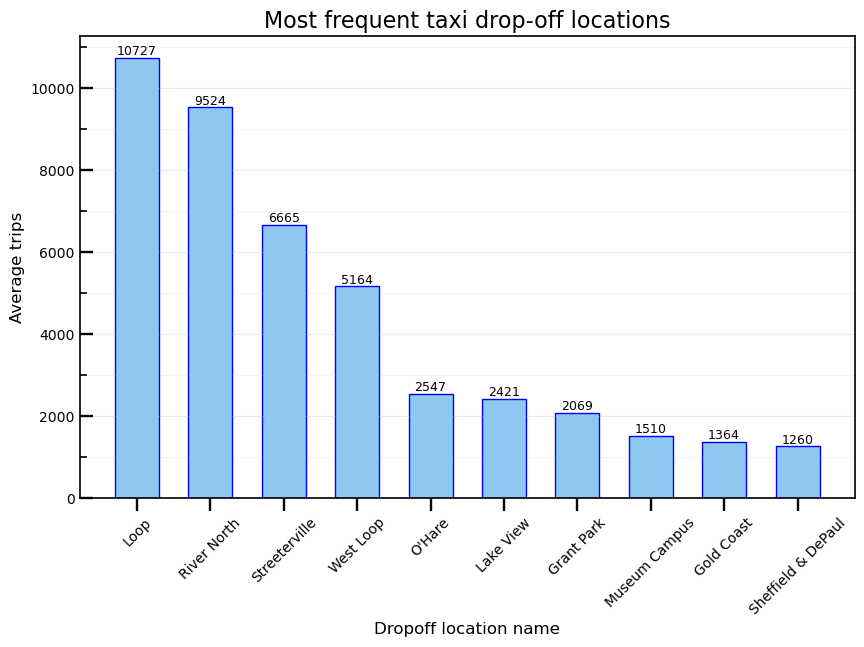

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    df_ten_most_popular_dropoff_locations['dropoff_location_name'],
    df_ten_most_popular_dropoff_locations['average_trips'],
    edgecolor='blue',
    width=0.6,
    linewidth=1.0,
    color="#8EC7F0",
    alpha=1
)
# Axis labels and title
ax.set_xlabel('Dropoff location name', fontsize=12)
ax.set_ylabel('Average trips', fontsize=12)
ax.set_title('Most frequent taxi drop-off locations', fontsize=16)

# Consistent axis framing across figures
for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.2)

ax.tick_params(labelsize=10)
ax.tick_params(axis='x', rotation=45)

# Subtle y-axis gridlines to aid comparison
ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color='#8EC7F0')
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.20, color='#8EC7F0')

# Apply shared tick styling helper for visual consistency
setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=2,
    major=(9, 1.7),
    minor=(5, 1.2),
    sides=dict(top=False, right=False, bottom=True, left=True),
    direction_top='in',
    direction_bottom='out',
    direction_left='in',
    direction_right='in'
)

for i, v in enumerate(df_ten_most_popular_dropoff_locations['average_trips']):
    ax.text(i, v + 0.5, f'{v:.0f}', ha='center', va='bottom', fontsize=9)

plt.show()

In [28]:
df_avg_trips_by_dropoff['average_trips'].describe()

count       94.000000
mean       599.953728
std       1714.591098
min          1.800000
25%         14.266667
50%         52.016667
75%        298.858333
max      10727.466667
Name: average_trips, dtype: float64

In [29]:
df_ten_most_popular_dropoff_locations['average_trips'].describe()

count       10.000000
mean      4324.986667
std       3530.183508
min       1259.766667
25%       1649.633333
50%       2483.933333
75%       6289.416667
max      10727.466667
Name: average_trips, dtype: float64

Urban taxi demand in November 2017 is highly centralized. Across 94 drop-off destinations, the average number of trips is 600, while the median is 52, indicating a right-skewed distribution. Most neighborhoods show low average trip volumes, whereas a small subset concentrates the highest demand. The top 10 destinations alone average more than 4,300 trips, with the Loop exceeding 10,700.

### 2.2. Taxi company demand distribution

In [30]:
df_ten_most_popular_companies = (
    df_company_trips
    .sort_values('trips_amount', ascending=False)
    .head(10)
)

In [31]:
df_company_trips['market_share_%'] = (
    df_company_trips['trips_amount'] /
    df_company_trips['trips_amount'].sum()
) * 100

df_ten_market_share_companies = (
    df_company_trips.sort_values('market_share_%', ascending=False).head(10)
)

In [32]:
show(df_ten_market_share_companies)

Loading ITables v2.7.0 from the internet... (need help?)


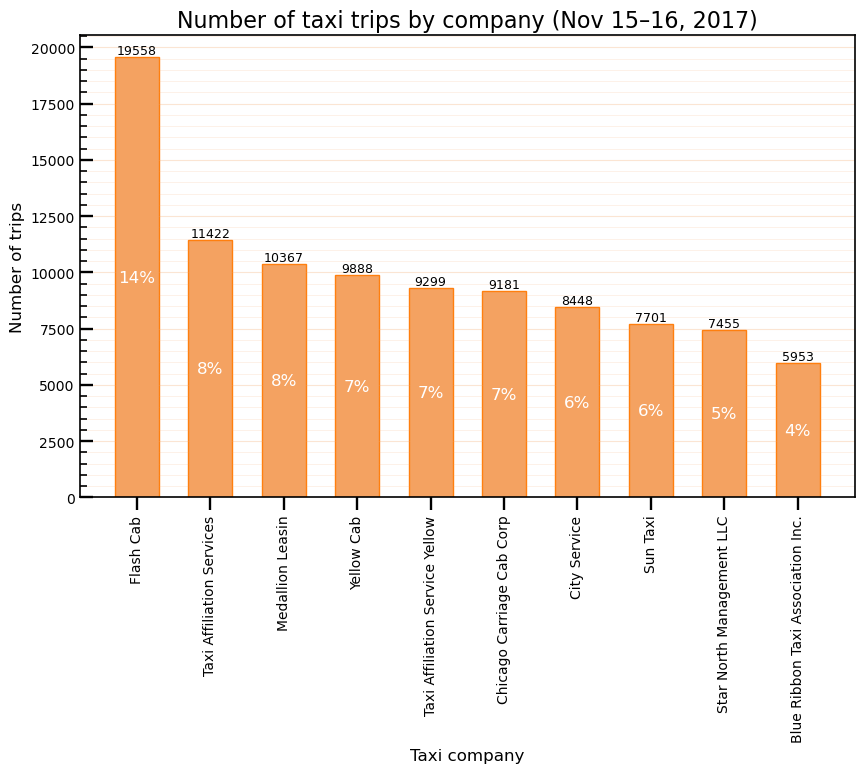

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    df_ten_most_popular_companies['company_name'],
    df_ten_most_popular_companies['trips_amount'],
    edgecolor='#FF7F0E',
    width=0.6,
    linewidth=1.0,
    color="#F4A261",
    alpha=1
)
# Axis labels and title
ax.set_xlabel('Taxi company', fontsize=12)
ax.set_ylabel('Number of trips', fontsize=12)
ax.set_title('Number of taxi trips by company (Nov 15–16, 2017)', fontsize=16)

# Consistent axis framing across figures
for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.2)

ax.tick_params(labelsize=10)
ax.tick_params(axis='x', rotation=90)

# Subtle y-axis gridlines to aid comparison
ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color='#F4A261')
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.20, color='#F4A261')

# Apply shared tick styling helper for visual consistency
setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=5,
    major=(9, 1.7),
    minor=(5, 1.2),
    sides=dict(top=False, right=False, bottom=True, left=True),
    direction_top='in',
    direction_bottom='out',
    direction_left='in',
    direction_right='in'
)

for i, (trips, pct) in enumerate(zip(
        df_ten_market_share_companies['trips_amount'],
        df_ten_market_share_companies['market_share_%']
    )):
    
    ax.text(i, trips + 0.5, f'{trips:.0f}', ha='center', va='bottom', fontsize=9)
    ax.text(i, trips/2, f'{pct:.0f}%', ha='center', va='center', fontsize=12, color='white')

plt.show()

In [34]:
flas_cab_dominance_ratio = df_ten_most_popular_companies['trips_amount'].iloc[0] / df_ten_most_popular_companies['trips_amount'].sum()
print(f"Dominance ratio of the Flash Cab company over the top ten companies combined: {flas_cab_dominance_ratio:.2%}")

Dominance ratio of the Flash Cab company over the top ten companies combined: 19.70%


In [35]:
first_vs_second_dominance_ratio = df_ten_most_popular_companies['trips_amount'].iloc[1] / df_ten_most_popular_companies['trips_amount'].iloc[0]
print(f"Dominance ratio of the taxi Affiliation Services over Flash Cab company: {first_vs_second_dominance_ratio:.2%}")

Dominance ratio of the taxi Affiliation Services over Flash Cab company: 58.40%


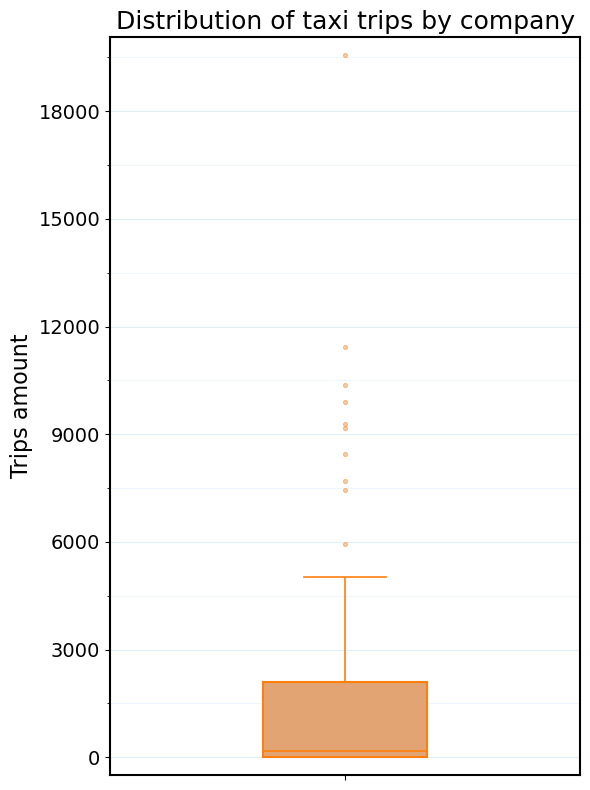

In [36]:
taxi_trips_by_company = df_company_trips['trips_amount']

fig, ax = plt.subplots(figsize=(6, 8))

sns.boxplot(
    y=taxi_trips_by_company, ax=ax, width=0.35, color='#F4A261', linewidth=1.5,
    showfliers=True,
    boxprops=dict(edgecolor='#FF7F0E'),
    whiskerprops=dict(color='#FF7F0E', linewidth=1.2),
    capprops=dict(color='#FF7F0E', linewidth=1.2),
    medianprops=dict(color='#FF7F0E', linewidth=1.2),
    flierprops=dict(
        marker='o',
        markerfacecolor='#F4A261',
        markeredgecolor='#FF7F0E',
        markersize=3,
        alpha=0.6,
        markeredgewidth=0.5
    )
)

# Labels / title
ax.set_ylabel('Trips amount', fontsize=16)
ax.set_title('Distribution of taxi trips by company', fontsize=18)
ax.set_xlabel('')

# Spines
for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.5)

ax.tick_params(labelsize=14)

# Limits
ymin, ymax = taxi_trips_by_company.min(), taxi_trips_by_company.max()
ax.set_ylim(ymin - 500, ymax + 500)

# Fix tick spam (use smart locators instead of MultipleLocator)
ax.yaxis.set_major_locator(MaxNLocator(nbins=8, integer=True))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Grid
ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color='#8EC7F0')
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.20, color='#8EC7F0')

plt.tight_layout()
plt.show()

In [37]:
df_company_trips['trips_amount'].describe()

count       64.000000
mean      2145.484375
std       3812.310186
min          2.000000
25%         20.750000
50%        178.500000
75%       2106.500000
max      19558.000000
Name: trips_amount, dtype: float64

Taxi trip volume is unevenly distributed across companies. Among 64 operators, the mean number of trips is 2,145, while the median is 178, reflecting a strongly right-skewed distribution. A small group of companies concentrates the highest trip volumes, with Flash Cab alone exceeding 19,500 trips (14% of total demand). The top three companies account for 30% of all trips, while the top ten concentrate 72%, indicating substantial market concentration. The boxplot reinforces this structure, most companies operate at low trip volumes, while a small number function as high-demand outliers, producing a long-tail distribution.

### 3. Hypothesis testing

In [38]:
show(df_loop_to_ohare_trips.sort_values(by='start_ts'))

Loading ITables v2.7.0 from the internet... (need help?)


In [39]:
df_loop_to_ohare_trips['start_ts'].dt.day_name().unique()

<StringArray>
['Saturday']
Length: 1, dtype: str

#### 3.1. Rain impact on trip duration - hypothesis test

The objective of this test is to determine whether rain affects the average duration of taxi trips from the Loop to O’Hare International Airport. The analysis focuses exclusively on trips occurring on Saturdays in November 2017. Two groups are compared: trips under rainy conditions and trips under non-rainy conditions. The test evaluates whether the mean trip durations of these groups differ statistically.

In [40]:
series_it_is_raining = df_loop_to_ohare_trips[df_loop_to_ohare_trips['weather_conditions'] == 'Bad']['duration_seconds']
series_it_is_not_raining = df_loop_to_ohare_trips[df_loop_to_ohare_trips['weather_conditions'] == 'Good']['duration_seconds']

##### 3.1.1. Hypotheses formulation

Null hypothesis (H_0): The average trip duration from the Loop to O’Hare International Airport on rainy Saturdays is equal to the average trip duration on non-rainy Saturdays.

Alternative hypothesis (H_1): The average trip duration from the Loop to O’Hare International Airport on rainy Saturdays is different from the average trip duration on non-rainy Saturdays.

In [41]:
# Significance level for the hypothesis test
alpha = 0.05

# Welch’s t-test to compare mean trip duration (Loop -> O’Hare) on rainy Saturdays vs non-rainy Saturdays
t_stat, p_value = stats.ttest_ind(series_it_is_raining, series_it_is_not_raining, equal_var=False)

# Decision based on the p-value
if p_value < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

print(p_value)

We reject the null hypothesis
9.126383933880059e-08


At a significance level of 0.05, we reject the null hypothesis. The p-value = 9.13x10^(-8) indicates a statistically significant difference in average trip duration between rainy and non-rainy Saturdays for trips from the Loop to O’Hare International Airport.

### 4. Overall conclusions

Taxi demand in Chicago is spatially and operationally concentrated. Among 94 drop-off destinations, the mean average trips is 600 while the median is 52, with the top 10 averaging over 4,300 and the Loop exceeding 10,700, indicating that trip activity is heavily centralized in a small group of core neighborhoods. Across 64 companies, the mean trip volume is 2,145 versus a median of 178. Flash Cab alone accounts for 14% of trips (19558 trips), while the top three concentrate 30% and the top ten 72% of total demand, reflecting a market where a limited number of operators capture most ride activity.

Additionally, hypothesis testing indicates a statistically significant difference in average trip duration between rainy and non-rainy Saturdays for trips from the Loop to O’Hare International Airport (p-value = 9.13x10^(-8), alpha = 0.05 significance level), confirming that weather conditions are associated with variations in travel time on this route.